# Pseudotime for GAMM pig retinal organoid sample

## First we use palantir to construct a pseudo time

In [17]:
# Palantir
# source venv/bin/activate
# load packages

import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

# variables
DATA_DIR = "/w5home/bmoore/scRNAseq/GAMM/human_data/reh_cellrep_2020/output_seurat_mapping_20230913_100651_cc/" # "/Users/bmoore/Desktop/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/"
ADATA_FILE = "gamms2_cca_pred.h5ad" # "gamms2_clustifyr.h5ad"
ANNOT_TYPE = "manual" # "seurat_map", "clustifyr", "manual"
CROSS_SPECIES = "TRUE" # "FALSE"
NC = 8 # number of components

In [3]:
# load data
## note- data was previously converted from seurat object to anndata object

data_dir = os.path.expanduser(DATA_DIR)
adata = sc.read_h5ad(data_dir + ADATA_FILE)
adata

AnnData object with n_obs × n_vars = 9716 × 14469
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sizeFactors', 'predicted.id', 'prediction.score.Prog', 'prediction.score.iMG', 'prediction.score.AC', 'prediction.score.Prog.Glia', 'prediction.score.PR', 'prediction.score.HC', 'prediction.score.RGC', 'prediction.score.BC', 'prediction.score.T1.T3', 'prediction.score.max', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'prediction.match', 'predicted.celltype.score', 'predicted.celltype'
    var: 'features'
    obsm: 'X_cca', 'X_pca', 'X_ref.umap', 'X_umap'
    varm: 'PCs'

In [4]:
# We have already preprocessed this data

# Now create a diffusion map

# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=NC)
# low dim embedding of the data is estimated based on the eigen gap
ms_data = palantir.utils.determine_multiscale_space(adata)

/w5home/bmoore/scRNAseq_library/sc_pipeline/src/pst_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


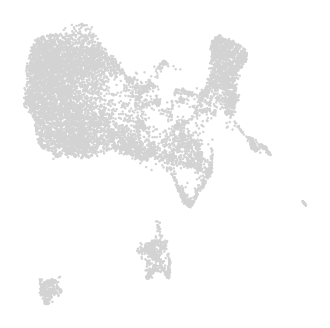

In [5]:
# visualize (note we have already done nearest neighbor and umap)
sc.pl.embedding(
    adata,
    basis="umap",
    frameon=False,
)

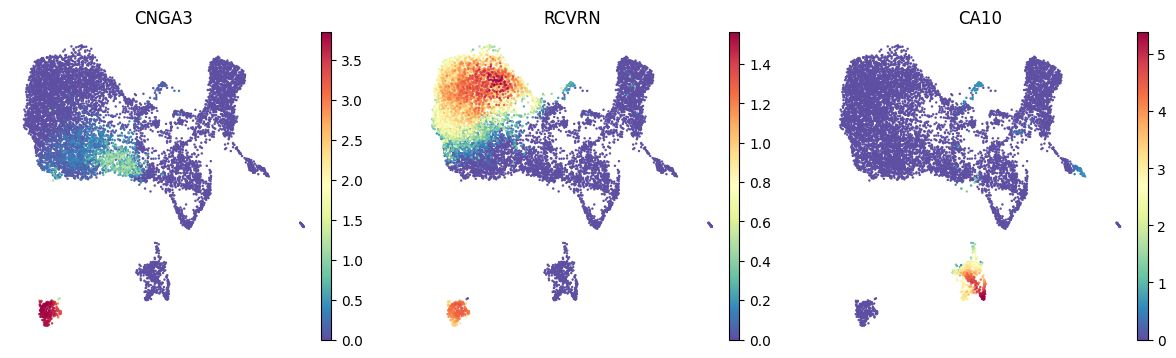

In [6]:
# MAGIC imputation
# Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.
imputed_X = palantir.utils.run_magic_imputation(adata)
# gene expression visualization on UMAP
if CROSS_SPECIES == "FALSE":
    genes = ["CNGA3", "RCVRN", "CA10", "TUBB3","SOX2"]
else:
    genes = ["CNGA3", "RCVRN", "CA10"]


with plt.rc_context():
    sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=genes,
    frameon=False,
    show=False,
    )
    plt.savefig(data_dir + "gene_expression.png")
#plt.show()

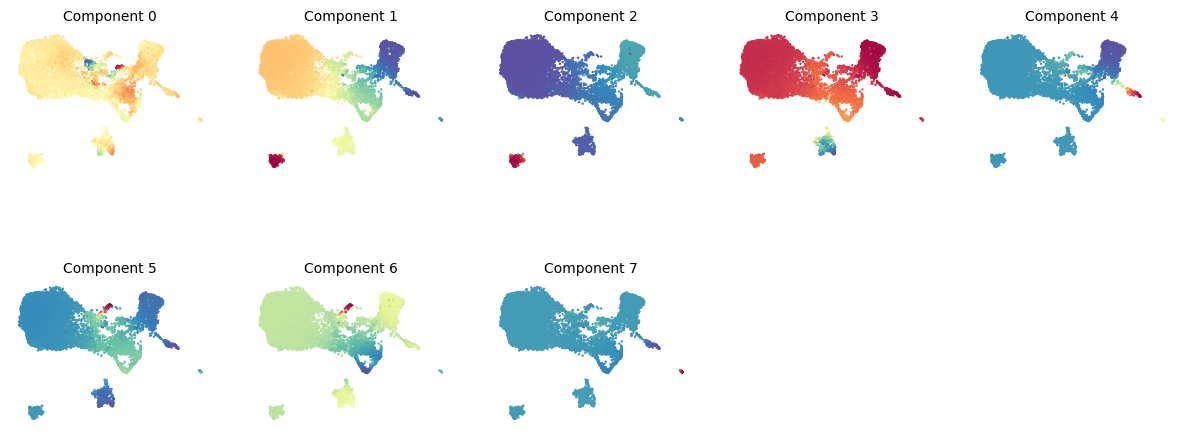

In [7]:
# Diffusion maps visualization
palantir.plot.plot_diffusion_components(adata)
plt.savefig(data_dir + 'palantir_components_umap.png')
plt.show()

In [8]:
# find terminal states

if ANNOT_TYPE == "clustifyr":
    # clustifyr
    set(adata.obs['clustifyr_call_consol_type'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs","Cones","Bipolar Cells", "Muller Glia"],celltype_column="clustifyr_call_consol_type")
elif ANNOT_TYPE == "manual":
    # manual annotation
    set(adata.obs['CellType'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs-Rods","Cones-Pan PRs","Bipolar Cells", "Muller Glia","Ganglion cell","Bipolar Cells-Ganglion cell"],celltype_column="CellType")
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping annotation
    set(adata.obs['predicted.celltype'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["AC","BC","HC", "PR","RGC","iMG"],celltype_column="predicted.celltype")
else:
    print("Error: invalid annotation type")

Using TCATTACAGCTGAGTG_2 for cell type Pan PRs-Rods which is min in diffusion component 1.
Using CTTCCGAGTACATACC_2 for cell type Cones-Pan PRs which is max in diffusion component 0.
Using TCGAAGTCAATACCCA_2 for cell type Bipolar Cells-Ganglion cell which is min in diffusion component 2.


/w5home/bmoore/scRNAseq_library/sc_pipeline/src/pst_env/lib/python3.10/site-packages/palantir/utils.py:927: UserWarning: No valid component found: Bipolar Cells Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Bipolar Cells will be skipped.
  warn(
/w5home/bmoore/scRNAseq_library/sc_pipeline/src/pst_env/lib/python3.10/site-packages/palantir/utils.py:927: UserWarning: No valid component found: Muller Glia Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Muller Glia will be skipped.
  warn(
/w5home/bmoore/scRNAseq_library/sc_pipeline/src/pst_env/lib/python3.10/site-packages/palantir/utils.py:927: UserWarning: No valid component found: Ganglion cell Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Ganglion cell will be skipped.
  warn(


In [9]:
set(adata.obs['predicted.celltype'])
print(terminal_states)

TCATTACAGCTGAGTG_2                   Pan PRs-Rods
CTTCCGAGTACATACC_2                  Cones-Pan PRs
TCGAAGTCAATACCCA_2    Bipolar Cells-Ganglion cell
dtype: object


In [10]:
# find start cell

if ANNOT_TYPE == "clustifyr":
    # clustifyr
    # use Retinal Prog to find start cell
    start_cell = palantir.utils.early_cell(adata,celltype="Retinal Prog",celltype_column="clustifyr_call_consol_type",fallback_seed=1234)
elif ANNOT_TYPE == "manual":
    # manual annotation
    # use Retinal Progenitor-Muller Glia to find start cell
    start_cell = palantir.utils.early_cell(adata,celltype="Retinal Progenitor-Muller Glia",celltype_column="CellType",fallback_seed=1234)
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping
    start_cell = palantir.utils.early_cell(adata,celltype="Prog",celltype_column="predicted.celltype",fallback_seed=1234)
else:
    print("Error: invalid annotation type")

Using GGTTCTCGTGTCTAAC_2 for cell type Retinal Progenitor-Muller Glia which is min in diffusion component 3.


Sampling and flocking waypoints...
Time for determining waypoints: 0.00868319272994995 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 3.788776326179504 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


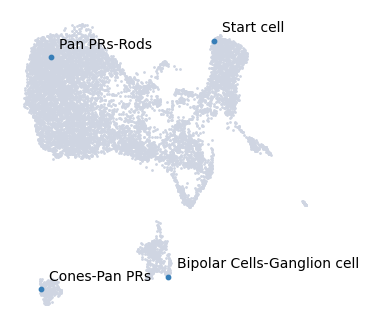

TCATTACAGCTGAGTG_2                   Pan PRs-Rods
CTTCCGAGTACATACC_2                  Cones-Pan PRs
TCGAAGTCAATACCCA_2    Bipolar Cells-Ganglion cell
dtype: object
TCATTACAGCTGAGTG_2                   Pan PRs-Rods
CTTCCGAGTACATACC_2                  Cones-Pan PRs
TCGAAGTCAATACCCA_2    Bipolar Cells-Ganglion cell
GGTTCTCGTGTCTAAC_2                     Start cell
dtype: object


In [11]:
# use cells found for start cell and terminal states for palantir analysis

# Run Palantir
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states
)

# to run without known terminal states
# pr_res2 = palantir.core.run_palantir(
#     adata, start_cell, num_waypoints=500
# )

# plot with terminal cells and start cell
all_cells = terminal_states.copy()
all_cells[start_cell] = "Start cell"
palantir.plot.highlight_cells_on_umap(adata, all_cells)
plt.savefig(data_dir + 'palantir_terminal_cells.png')
plt.show()

print(terminal_states)
print(all_cells)

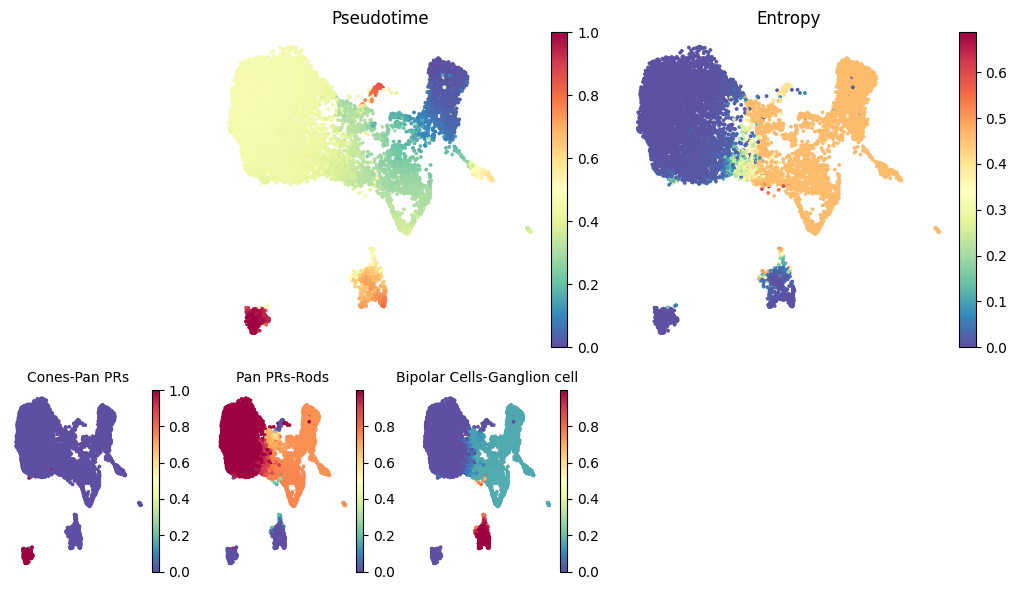

In [12]:
# plot results
palantir.plot.plot_palantir_results(adata, s=3)
plt.savefig(data_dir + 'palantir_results.png')
plt.show()

Index(['TCATTACAGCTGAGTG_2', 'CTTCCGAGTACATACC_2', 'TCGAAGTCAATACCCA_2',
       'GGTTCTCGTGTCTAAC_2'],
      dtype='object')


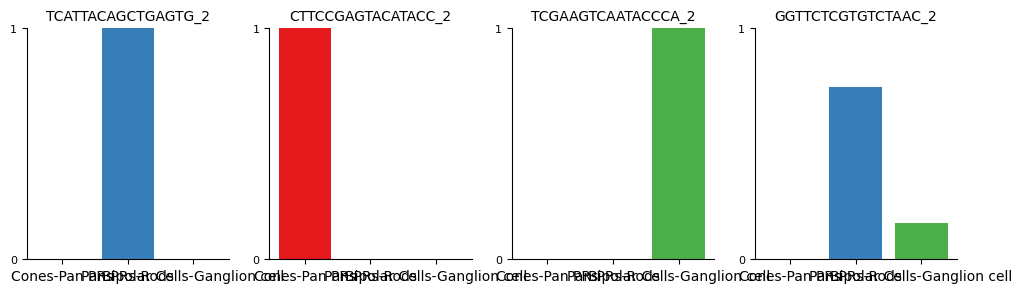

In [13]:
# Terminal state probability distributions of individual cells can be visualized using the plot_terminal_state_probs function

cells=all_cells.index
print(cells)
palantir.plot.plot_terminal_state_probs(adata, cells)
plt.savefig(data_dir + 'terminal_state_probs.png')
plt.show()

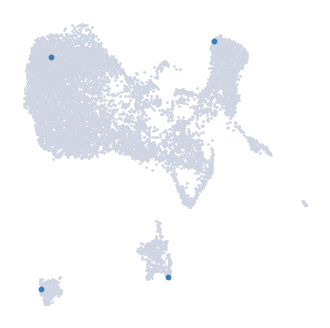

In [14]:
# highlight cells on UMAP
palantir.plot.highlight_cells_on_umap(adata, cells)
plt.show()

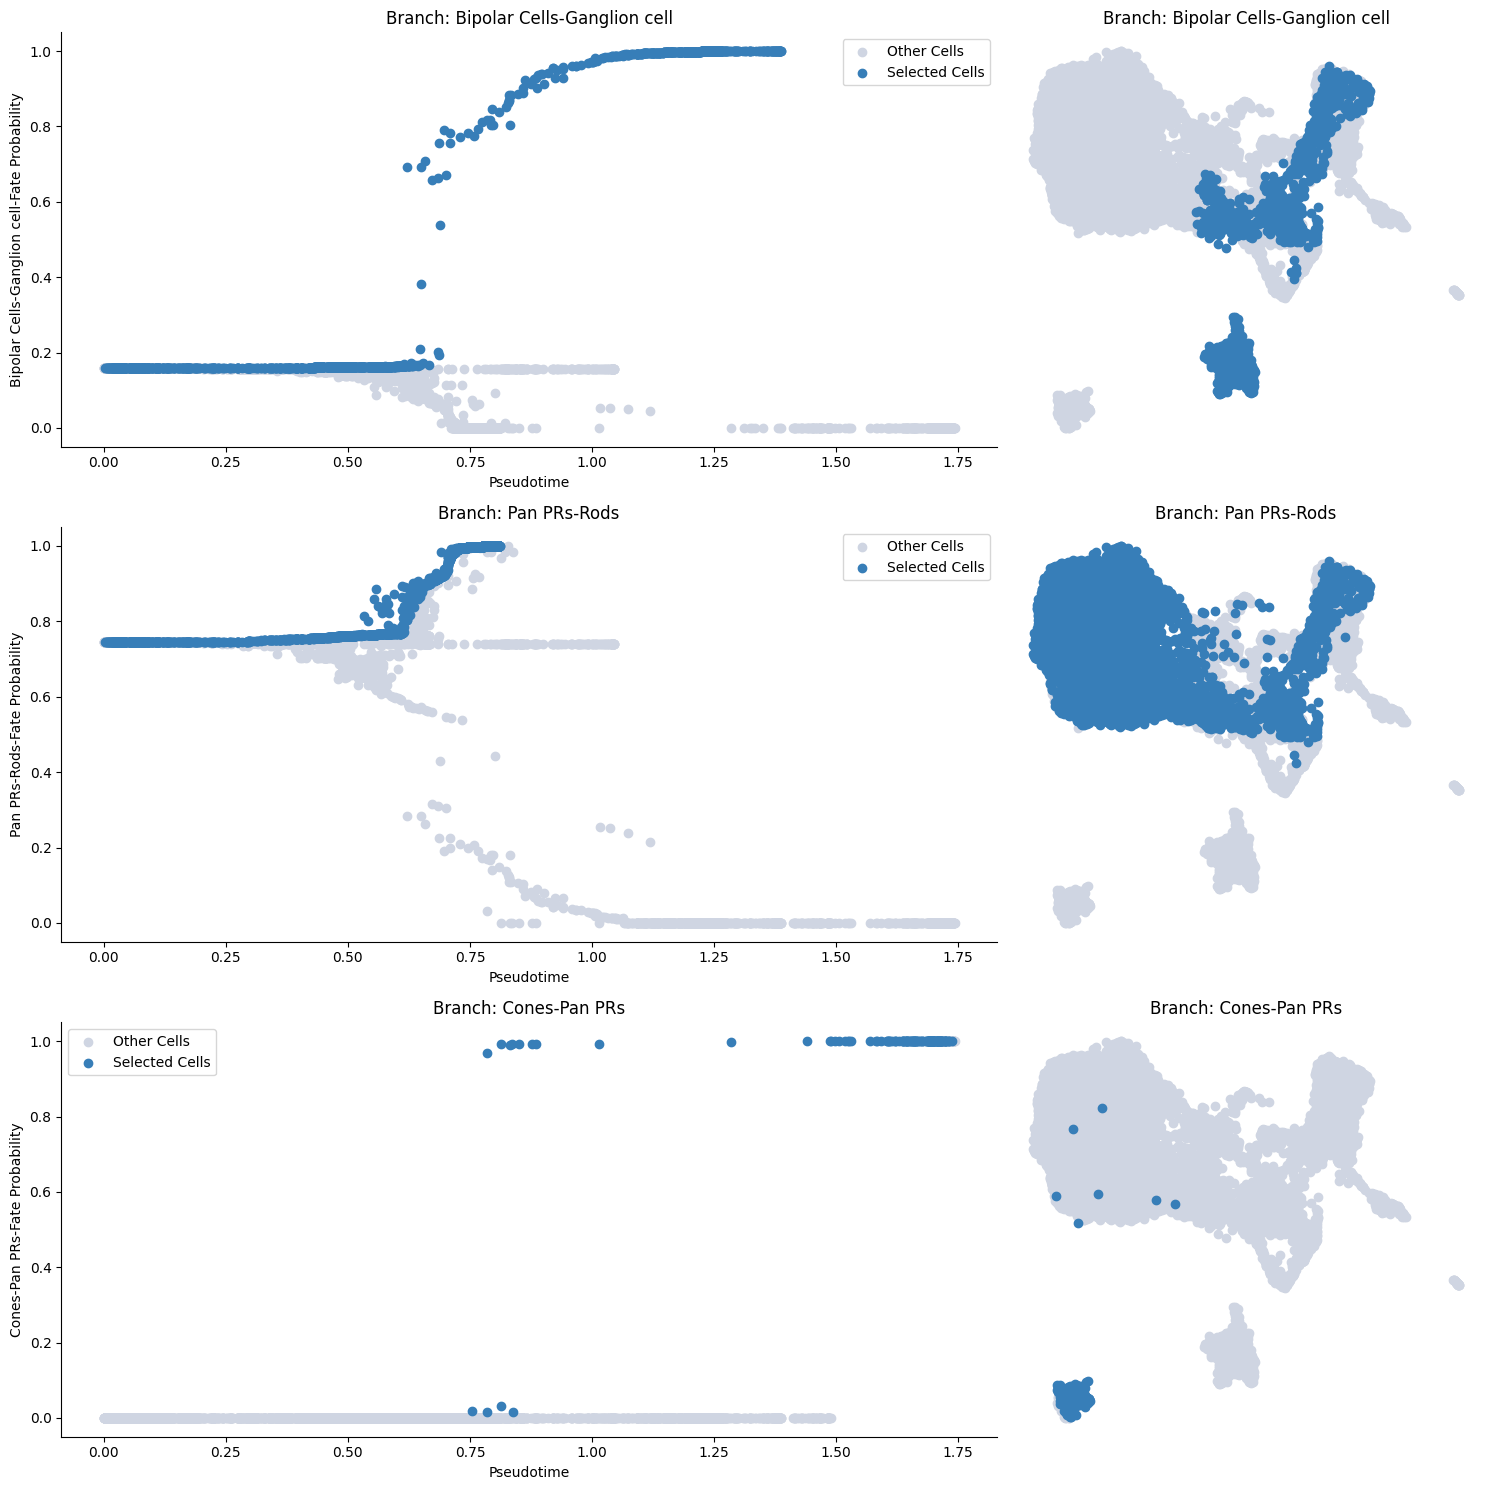

In [15]:
# Branch probabilities

# Select cells
# Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory.
masks = palantir.presults.select_branch_cells(adata, eps=0)
# visualize the branck selection
palantir.plot.plot_branch_selection(adata)
plt.savefig(data_dir + 'branch_selection.png')
plt.show()

Cones-Pan PRs
[2023-10-20 11:13:24,239] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (143) and rank = 1.0.
[2023-10-20 11:13:24,239] [INFO    ] Using covariance function Matern52(ls=1.0).


Pan PRs-Rods
[2023-10-20 11:13:25,282] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (6,072) and rank = 1.0.
[2023-10-20 11:13:25,284] [INFO    ] Using covariance function Matern52(ls=1.0).
Bipolar Cells-Ganglion cell
[2023-10-20 11:13:26,172] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,476) and rank = 1.0.
[2023-10-20 11:13:26,173] [INFO    ] Using covariance function Matern52(ls=1.0).


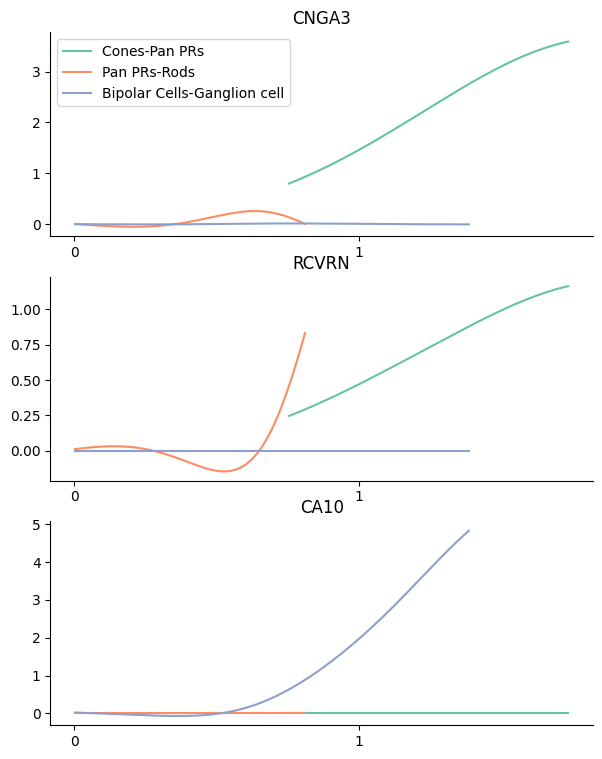

In [18]:
# Determine marker gene trends using the  Mellon Function Estimator
gene_trends = palantir.presults.compute_gene_trends(
    adata,
    expression_key="MAGIC_imputed_data",
)
# visualize trends
if CROSS_SPECIES == "FALSE":
    genes = ["CNGA3", "RCVRN", "CA10", "TUBB3","SOX2"]
    palantir.plot.plot_gene_trends(adata, genes)
    plt.savefig(data_dir + 'gene_trends.png')
    plt.show()
else:
    genes = ["CNGA3", "RCVRN", "CA10"]
    palantir.plot.plot_gene_trends(adata, genes)
    plt.savefig(data_dir + 'gene_trends.png')
    plt.show()

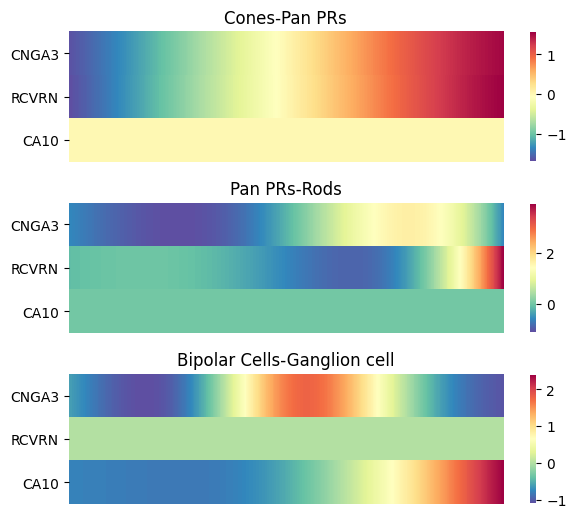

In [19]:
# Heatmap trend visualization
palantir.plot.plot_gene_trend_heatmaps(adata, genes)
plt.savefig(data_dir + 'gene_trends_heatmap.png')
plt.show()

/w5home/bmoore/scRNAseq_library/sc_pipeline/src/pst_env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


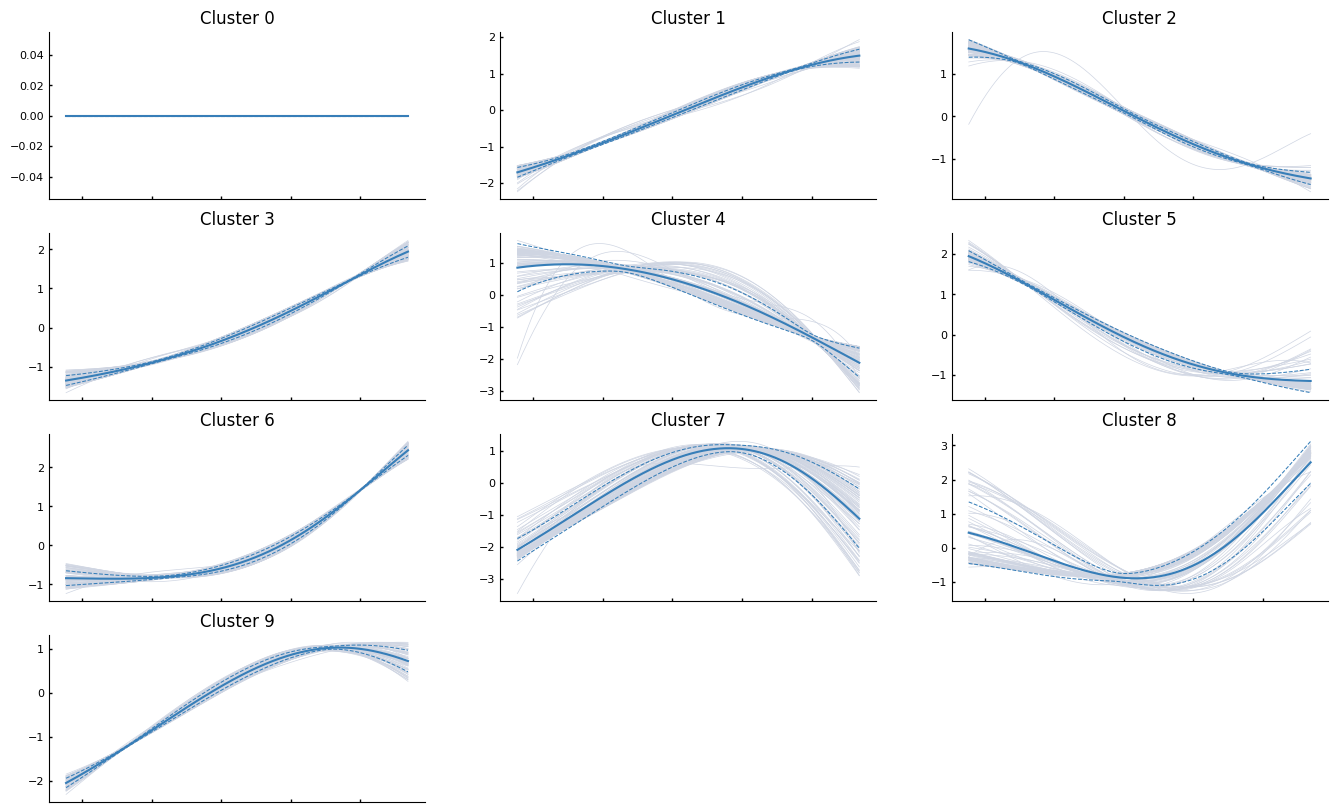

In [20]:
# Clustering
# Gene expression trends can be clustered and visualized
# Here the first 1000 genes along the cones genes are clustered
more_genes = adata.var_names[:1000]
if ANNOT_TYPE == "clustifyr":
    # clustifyr
    communities = palantir.presults.cluster_gene_trends(adata, "Cones", more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, "Cones")
elif ANNOT_TYPE == "manual":
    # manual annotation
    communities = palantir.presults.cluster_gene_trends(adata, "Cones-Pan PRs", more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, "Cones-Pan PRs")
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping
    communities = palantir.presults.cluster_gene_trends(adata, "PR", more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, "PR")
else:
    print("Error: invalid annotation type")
# save figure and show
plt.savefig(data_dir + 'gene_trend_clusters.png')
plt.show()

In [21]:
adata
# weird seurat to anndata thing- anndata doesn not like a column named _index
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [22]:
import numpy as np
import cellrank as cr
import scanpy as sc
import scvelo as scv
# compute diffusion pseudotime (DPT)
# start by computing a diffusion map
# need to recompute nearest neighbots first
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.diffmap(adata)

In [23]:
# find root cell
root_ixs = adata.obsm['X_diffmap'][:, 3].argmax()
print(root_ixs)

3507


saving figure to file /w5home/bmoore/scRNAseq/GAMM/human_data/reh_cellrep_2020/output_seurat_mapping_20230913_100651_cc/diffusion_map.png


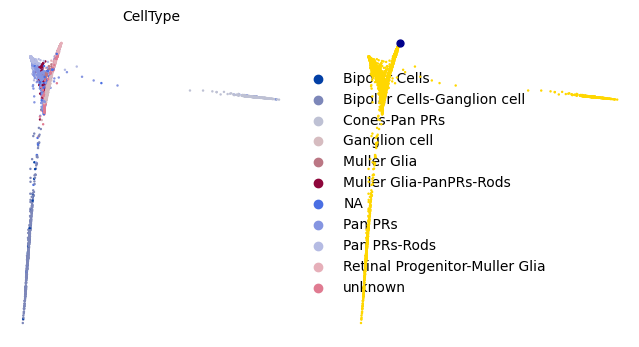

In [24]:
# visualize and set root

if ANNOT_TYPE == "clustifyr":
    scv.pl.scatter(
    adata,
    basis="diffmap",
    c=['clustifyr_call_consol_type', root_ixs],
    legend_loc="right",
    components=["2, 3"],
    save= data_dir +'diffusion_map.png'
    )
    
elif ANNOT_TYPE == "manual":
    scv.pl.scatter(
    adata,
    basis="diffmap",
    c=['CellType', root_ixs],
    legend_loc="right",
    components=["2, 3"],
    save= data_dir +'diffusion_map.png'
    )
    
elif ANNOT_TYPE == "seurat_map":
    scv.pl.scatter(
        adata,
        basis="diffmap",
        c=['predicted.celltype', root_ixs], # clustifyr_call_consol_type, CellType
        legend_loc="right",
        components=["2, 4"],
        save= data_dir +'diffusion_map.png'
    )
    
adata.uns["iroot"] = root_ixs

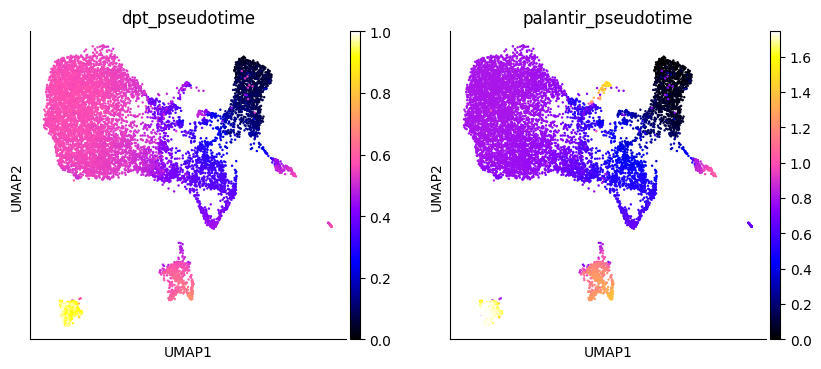

In [25]:
# Compute DPT and compare it with the precomputed Palantir pseudotime:
sc.tl.dpt(adata)
with plt.rc_context():
    sc.pl.embedding(
    adata,
    basis="umap",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
    show=False
    )
    plt.savefig(data_dir +'dpt-palantir_pseudotime.png')

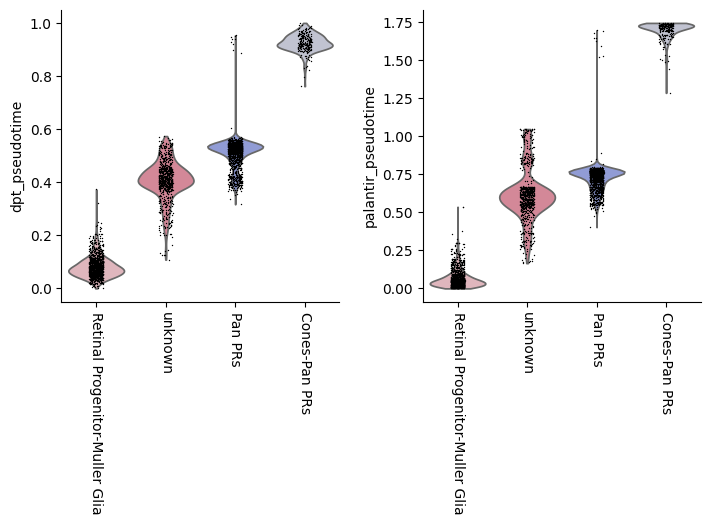

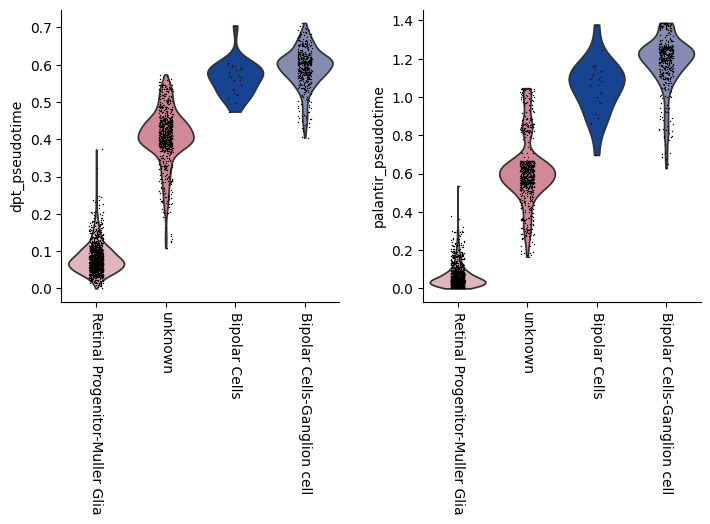

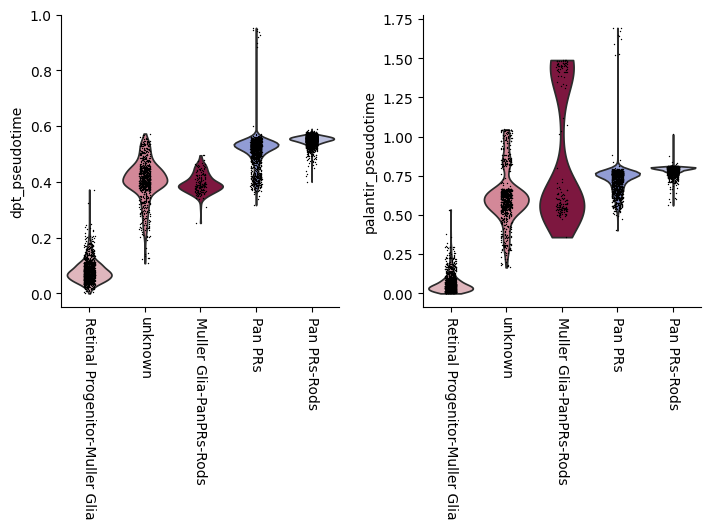

In [26]:
# plot trajectory
cone_trajectory = "NA"
bipolar_trajectory = "NA"
rod_trajectory = "NA"
pr_trajectory = "NA"
img_trajectory = "NA"
ac_trajectory = "NA"

if ANNOT_TYPE == "clustifyr":
    cone_trajectory = ["Retinal Prog", "Pan PRs", "Cones"]
    bipolar_trajectory = ["Retinal Prog", "Muller Glia", "Bipolar Cells"]
    rod_trajectory = ["Retinal Prog", "Pan PRs"]
    key= "clustifyr_call_consol_type"
elif ANNOT_TYPE == "manual":
    cone_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Pan PRs","Cones-Pan PRs"]
    bipolar_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Bipolar Cells","Bipolar Cells-Ganglion cell"]
    rod_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Muller Glia-PanPRs-Rods","Pan PRs","Pan PRs-Rods"]
    key= "CellType"
elif ANNOT_TYPE == "seurat_map":
    pr_trajectory = ["Prog","Prog/Glia","PR"]
    bipolar_trajectory = ["Prog","Prog/Glia","BC"]
    img_trajectory = ["Prog","Prog/Glia","iMG"]
    ac_trajectory = ["Prog","Prog/Glia","AC"]
    key= "predicted.celltype"

# # plot the cone trajectory
if cone_trajectory != "NA":
    mask = np.in1d(adata.obs[key], cone_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=cone_trajectory,
        show=False
        )
        plt.savefig(data_dir +'cone_trajectory.png')

# # plot the bipolar trajectory
if bipolar_trajectory != "NA":
    mask = np.in1d(adata.obs[key], bipolar_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=bipolar_trajectory,
        show=False
        )
        plt.savefig(data_dir +'bipolar_trajectory.png')

# # plot the rod trajectory
if rod_trajectory != "NA":
    mask = np.in1d(adata.obs[key], rod_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=rod_trajectory,
        show=False
        )
        plt.savefig(data_dir +'rod_trajectory.png')

# plot the PR trajectory
if pr_trajectory != "NA":
    mask = np.in1d(adata.obs[key], pr_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=pr_trajectory,
        show=False
        )
        plt.savefig(data_dir +'pr_trajectory.png')

# plot the iMG trajectory
if img_trajectory != "NA":
    mask = np.in1d(adata.obs[key], img_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=img_trajectory,
        show=False
        )
        plt.savefig(data_dir +'img_trajectory.png')

# plot the AC trajectory
if ac_trajectory != "NA":
    mask = np.in1d(adata.obs[key], ac_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=ac_trajectory,
        show=False
        )
        plt.savefig(data_dir +'ac_trajectory.png')


In [27]:
# Compute a transition matrix based on Palantir pseudotime
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

print(pk)

  0%|          | 0/9716 [00:00<?, ?cell/s]

100%|██████████| 9716/9716 [00:05<00:00, 1682.06cell/s]


PseudotimeKernel[n=9716]


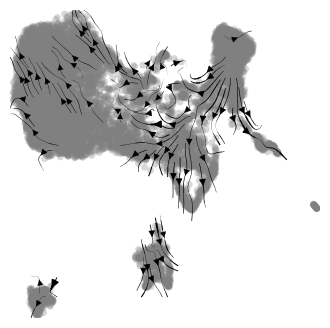

In [28]:
# visualize based on pseudotime and transition matrix
with plt.rc_context():
    pk.plot_projection(basis="umap", recompute=True, show=False)
    plt.savefig(data_dir +'pseudotime_transition.png')

In [29]:
# Save results
file_path = os.path.join(data_dir, "GAMMS2_pseudotime_processed.h5ad")
adata.write(file_path)
# package versions
import pkg_resources

for package in pkg_resources.working_set:
    print(package.key, pkg_resources.get_distribution(package).version)

fsspec 2023.9.2
xarray 2023.9.0
certifi 2023.7.22
pytz 2023.3.post1
tzdata 2023.3
tbb 2021.10.0
setuptools 65.5.0
pyzmq 25.1.1
pip 23.2.1
packaging 23.2
attrs 23.1.0
contextlib2 21.6.0
rich 13.6.0
nvidia-nvjitlink-cu12 12.3.52
nvidia-cuda-cupti-cu12 12.1.105
nvidia-cuda-nvrtc-cu12 12.1.105
nvidia-cuda-runtime-cu12 12.1.105
nvidia-nvtx-cu12 12.1.105
nvidia-cublas-cu12 12.1.3.1
nvidia-cusparse-cu12 12.1.0.106
nvidia-cusolver-cu12 11.4.5.107
websockets 11.0.3
nvidia-cufft-cu12 11.0.2.54
nvidia-curand-cu12 10.3.2.106
pillow 10.0.1
ipython 8.16.1
nvidia-cudnn-cu12 8.9.2.26
natsort 8.4.0
jupyter-client 8.4.0
click 8.1.7
ipykernel 6.25.2
deepdiff 6.6.0
tornado 6.3.3
importlib-resources 6.1.0
multidict 6.0.4
pyyaml 6.0.1
traitlets 5.11.2
psutil 5.9.5
jupyter-core 5.4.0
decorator 5.1.1
tzlocal 5.1
tqdm 4.66.1
fonttools 4.43.1
protobuf 4.24.4
beautifulsoup4 4.12.2
typing-extensions 4.8.0
pexpect 4.8.0
gdown 4.7.1
progressbar2 4.2.0
ordered-set 4.1.0
readchar 4.0.5
async-timeout 4.0.3
cmake 3.27.